###Optimising Maintenance Schedule
In this part, we aim to determine the shortest route that will allow the maintenance crew to fix all the various wells that are either in need of repair or not functional. Some factors which we may wish to consider:

i) Can we assign a higher priority to wells which are not functional as opposed to those that are merely not working?

ii) Can we take advantage of route information to concentrate on higher quality roads?

Initially we will ignore differences in location, height etc. and assume that all points on the map are equally accessible. To calculate the pairwise distance between points we need to take account of the fact that the Earth is a sphere so we need to use the Haversine formula: 

$$\rm{haversin} \Big(\frac{d}{r}\Big) = \rm{haversin}(\phi_2 - \phi_1) + \rm{cos}(\phi_1)\,\,\rm{cos}(\phi_2)\,\,\rm{haversin}(\lambda_1 - \lambda_2)$$

$$\rm{haversin}(\theta) = \rm{sin}^2\Big(\frac{\theta}{2}\Big) = \frac{1 - \rm{cos}(\theta)}{2} $$

where $d$ is the distance between the two points, $r$ is the radius of the sphere (Earth), $\phi$ is the latitude and $\theta$ is the longitude. This can be rearranged to give the following formula as described in (R. W. Sinnott, "Virtues of the Haversine," Sky and Telescope, vol. 68, no. 2, 1984, p. 159):

  $$\rm{dlon} = \rm{lon2} - \rm{lon1}$$
  $$\rm{dlat} = \rm{lat2} - \rm{lat1}$$
  $$\rm{a} = (\rm{sin}(\frac{dlat}{2}))^2 + cos(lat1) \times cos(lat2) \times (sin(\frac{dlon}{2}))^2$$
  $$\rm{c} = 2 \times \rm{arctan}(\frac{\sqrt{a}}{\sqrt{1-a}})$$ 
  $$\rm{d} = \rm{R} \times \rm{c}$$


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time
import seaborn as sns
from math import radians, sin, cos, asin, sqrt, pi, atan2

In [3]:
def getDistanceByHaversine(latitudes, longitudes):
    '''Haversine formula - give coordinates as a 2D numpy array of
    (lat_decimal,lon_decimal) pairs'''
    
    # earth's mean radius = 6,371km
    EARTHRADIUS = 6371.0
    
    # create meshgrid:
    lat, lon = np.meshgrid(latitudes, longitudes)
    
    # convert to radians
    lat *= np.pi / 180.0
    lon *= np.pi / 180.0
    
    # get transposed meshgrids for distances
    lat_T = lat.T.copy()
    lon_T = lon.T.copy()

    dlon = lon_T - lon
    dlat = lat_T - lat
    
    a = (np.sin(dlat/2))**2 + np.cos(lat) * np.cos(lat_T) * (np.sin(dlon/2.0))**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    km = EARTHRADIUS * c
    return km

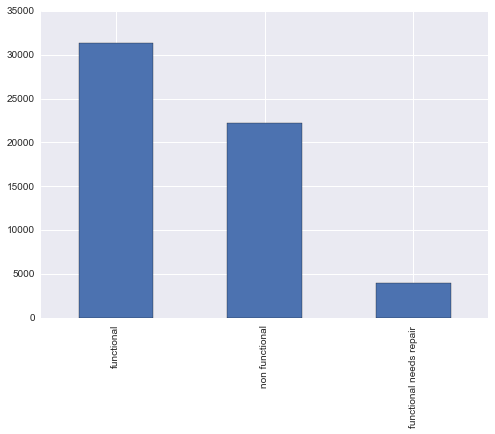

In [59]:
from pandas import Series, DataFrame, Panel

#import data and labels
train_file = pd.read_csv('Waterpump-training-values.csv')
train_labels = pd.read_csv('Waterpump-training-labels.csv')

train_file['status_group'] = train_labels['status_group']
train_file = train_file[train_file['longitude'] > 1]
train_file = train_file[train_file['latitude'] < 0]

features = ['longitude','latitude','status_group']
trainLoc = train_file[features]


# pandas barplot
trainLoc['status_group'].value_counts().plot(kind='bar');

In [60]:
trainLoc = trainLoc[trainLoc['status_group'] != 'functional']
#trainLoc.head()

#subsetting data to just take 1% to make it easier to work with
np.random.seed(142)
test_idx = np.random.uniform(0, 1, len(trainLoc)) <= 0.01
trainLoc = trainLoc[test_idx==True]


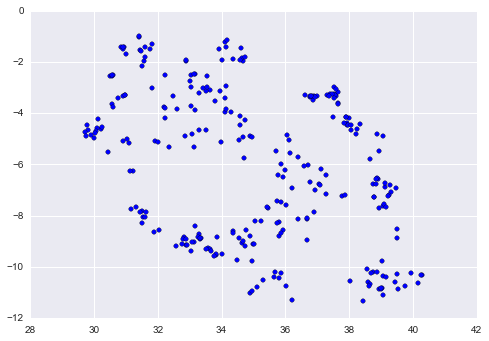

In [74]:
x = np.array(trainLoc['longitude'])#.tolist()
y = np.array(trainLoc['latitude'])#.tolist()

#insert coordinates for Dar Es Salaam (39.2833 E 6.8000S)
x = np.insert(x, 0, 39.2833, 0)
y = np.insert(y, 0, -6.8000, 0)
DarEs = np.array([39.2833, -6.800])

#A = numpy.array((x, y, z), dtype=float)
#tmpx, tmpy =  np.meshgrid(x,y)

cities = np.array((x, y), dtype=float)
#cities = np.array([tmpx, tmpy])
cities = np.reshape(cities, (2,-1)).T
#print cities.shape
#print cities


plt.scatter(cities[:,0], cities[:,1])

[ 39.2833  -6.8   ]


In [62]:
cities[:10,0], cities[:10,1]

(array([ 30.12668109,  40.30198716,  34.4797207 ,  31.51069241,
         37.55061829,  37.65935713,  38.86390269,  35.78213156,
         37.79203542,  32.19511383]),
 array([ -4.23637808, -10.32095944,  -9.72147456,  -7.83669775,
         -3.28840021,  -3.17139227,  -4.82050615,  -6.41706671,
         -7.24196371,  -3.75538313]))

In [63]:
# the distance between two cities is just
# the norm of the difference vector
def get_distance(city1, city2):
    #return np.linalg.norm(city1 - city2)

    '''Haversine formula - give coordinates as a 2D numpy array of
    (lat_decimal,lon_decimal) pairs'''
    #print city1[:], city2[:]
    # earth's mean radius = 6,371km
    EARTHRADIUS = 6371.0
    
    # create meshgrid:
    lat0, lon0 = city1[1], city1[0]#np.meshgrid(city1[1], city1[0])
    lat1, lon1 = city2[1], city2[0]#np.meshgrid(city2[1], city2[0])
    
    # convert to radians
    lat0 *= np.pi / 180.0
    lon0 *= np.pi / 180.0
    lat1 *= np.pi / 180.0
    lon1 *= np.pi / 180.0
    
    # get transposed meshgrids for distances
    #lat1_T = lat1.T.copy()
    #lon1_T = lon1.T.copy()

    #dlon = lon_T - lon
    #dlat = lat_T - lat
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    
    a = (np.sin(dlat/2))**2 + np.cos(lat0) * np.cos(lat1) * (np.sin(dlon/2.0))**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    km = EARTHRADIUS * c
    return km

# the energy for the whole system corresponds to
# the total distance the salesman has to travel
def distance(pathcities):
    distance = 0.
    number_of_cities = pathcities.shape[0]
    
    # loop over all cities
    for j in xrange(number_of_cities):
        if j == number_of_cities - 1: # FINAL POINT CONNECTS WITH THE FIRST ONE
            distance += get_distance( pathcities[j,:], pathcities[0,:] )
        else:
            distance += get_distance( pathcities[j,:], pathcities[j+1,:] )
    return distance

#get_distance(cities[0], cities[1])

1309.9886645502006

In [93]:
# create a new path by swapping the connection between
# n_swaps cities randomly
def changepath(inputcities, n_swaps):
    indices = range(1,inputcities.shape[0]) #Don't include starting city in swaps so that HQ is always the same
    cities = inputcities.copy()
    for i in range(n_swaps):
        swappedCities = swapindex(cities)
        cities=swappedCities.copy()

    return cities

def swapindex(cities):
    indices = range(1,cities.shape[0]) #Don't include starting city in swaps so that HQ is always the same
    # take two random indices to swap
    c1 = np.random.choice(indices)
    c2 = np.random.choice(indices)
    
    while c2 == c1:
        c2 = np.random.choice(indices) 
    
    # remember the cities to swap
    tmp1 = cities[c1,:]
    tmp2 = cities[c2,:]
    
    # do the actual swapping
    changedCities = cities.copy()
    changedCities[c1,:] = tmp2
    changedCities[c2,:] = tmp1
    
    return changedCities

In [115]:
print DarEs[0], DarEs[1]

39.2833 -6.8


In [154]:
def plot_path(pcities):
    plt.plot(pcities[1:,0], pcities[1:,1],'o')
    plt.plot(pcities[1:,0], pcities[1:,1])
    plt.scatter(DarEs[0],DarEs[1], s=500, color='red') #Highlight Dar Es Salaam on Map as HQ
    plt.xlim(np.min(pcities[:,0])-1, np.max(pcities[:,0])+1)
    plt.ylim(np.min(pcities[:,1])-1, np.max(pcities[:,1])+1)

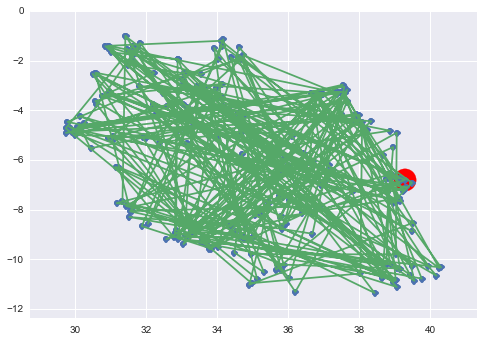

In [155]:
# permute cities to get a random path
rand_ind = np.random.permutation(np.shape(cities)[0])

cities = cities[rand_ind, :]
plot_path(cities)


[[ 13]
 [146]]
[[[ 32.80519299  -8.93107888]]

 [[ 35.86216981  -5.97312346]]]


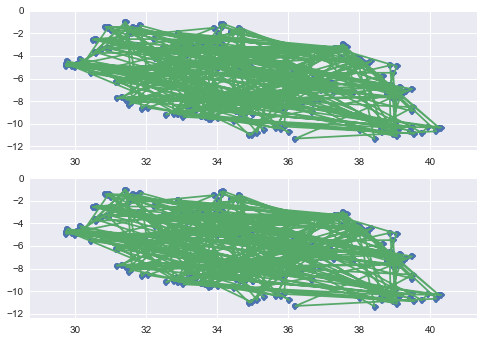

In [67]:
cities_before = cities.copy()

plt.subplot(2,1,1)
plot_path(cities)

cities = changepath(cities, 1)

plt.subplot(2,1,2)
plot_path(cities)

changedIndices = np.argwhere(np.abs(cities_before - cities)[:,0] > 0)
print changedIndices
print cities[changedIndices,:]

In [98]:
# function for simulated annealing
# pathcities: array with our cities represented by their coordinates
# init_temp: initial temperature 
# thermostat: linear factor to decrease the temperature 
# ftol, itol, otol: tolerance values for stopping
# reannealing: schedule for reheating

def simulated_annealing( pathcities, init_temp, thermostat, ftol, itol, otol, reannealing):
    # ===============
    # SET THESE FOR DIAGNOSTICS
    # ================

    m=100000     
    distsize=otol+1
    dist=[]
    temperature = init_temp   


    N = pathcities.shape[0]
    
    # number of accepted steps
    it = 0                    

    # DISTANCE HERE IS OUR ENERGY 
    prev_E = distance(pathcities)  
    
    # number of iterations
    atp=0
    
    didPlot = False
    
    while it >=0:
    #while otol < itol:
        ## NUMBER OF CORNERS IS L
        L = np.max((np.floor(np.sqrt(temperature)).astype(int),1))
        #print "L", L
        #L = 2
        #print "!: ", pathcities[0]
        propose_path = changepath(pathcities, L) #GH - trying to avoid changing first city
        #print "2: ", pathcities[0]

        new_E = distance(propose_path)
        deltaE  =  new_E -prev_E 

        if new_E < prev_E:
            #print "5: ", pathcities[0]
            pathcities  = propose_path
            #print "3: ", pathcities[0]
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E  
            it = it+1
            didPlot = False
            
        elif np.random.rand() < np.exp( -deltaE/temperature):
            pathcities  = propose_path
            #print "4: ", pathcities[0]
            #dist[it] =new_E
            dist.append(new_E)
            prev_E = new_E 
            it = it+1
            didPlot = False

        atp =atp +1;  # NUMBER OF ITERATIONS
        
        # check if it is time to cool down
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            #temperature =  temperature/log(it);
            compl_temp=0;
            
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 1
        
        if False: #some optional plotting
            if (it % 100 == 0) and not didPlot:       
                display.clear_output()
                plt.plot( dist, '-r')
                display.display(plt.gcf())
                print len(dist)
                print raw_input('Iteration: ' + np.str(atp))
                plt.close()
                didPlot = True
    
        if len(dist)>m and np.std(dist[-m:])/np.mean(dist[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(dist)> 0 and dist[-1] <= otol:
            print 'otol'
            print dist[-1]
            break

    s = pathcities
    return s, dist

In [101]:
# simulated_annealing( pathcities, init_temp, thermostat, ftol, itol, otol, reannealing):
pcities, distances = simulated_annealing(cities, 10.0, 0.8, 0.01, 20000, 0, 10)

print len(distances)

itol
702


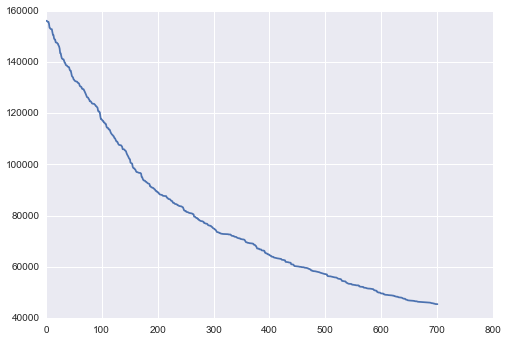

In [102]:
plt.plot(distances)

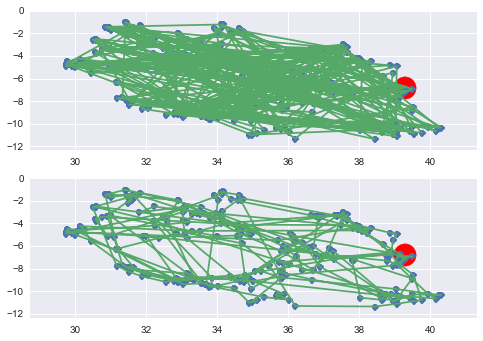

In [156]:
plt.subplot(2,1,1)
plot_path(cities)

plt.subplot(2,1,2)
plot_path(pcities)


In [105]:
print pcities[

[ 38.74580877  -6.75654194]


###Things to do:
1) Set Dar Es Salaam (39.2833 E 6.8000S) as starting/ending point. DONE

2) Set Maximum Distance that can be travelled in one day.

3) Priortize pumps that have a small number of nearest neighbours.

4) Travelling Purchaser Problem where non-functioning pumps cost more to repair than 'needs repair'.